- **Name:** Convertion rate
- **Date:** 09/04/2019
- **By:** Qian Du
- **Goals**

1.Perform Exploratory Data Analysis and produce 2-3 plots that show either important features or interesting patterns in the data. It is up to you what you want to highlight.
2.Build a model to predict conversion rate and critically evaluate it, explaining your choice of model and performance metric.
3.Come up with recommendations for the product team and the marketing team to improve conversion rate.
    
## Part I. Exploratory Data analysis

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
%config InlineBackend.figure_format = 'svg' 

In [15]:
# Import dataset
Raw_data = pd.read_csv("/data/conversion_data.csv")
Raw_data.head()
# Raw_data.info() # no missing data; can't define duplicated data
# Raw_data.describe() # low convertion rate, imbalanced conversion rate
                    # meaningful and not obvious outliers
# Raw_data.country.value_counts(normalize=True)
# Raw_data.source.value_counts(normalize=True)
Raw_data = Raw_data[Raw_data.age < 100]
# comment: we have two people with wierd ages, Talk with the data collector in case something goes 
# wrong with the whole pipeline.

**Comment:** no missing data; 316200 samples, 5 features. 

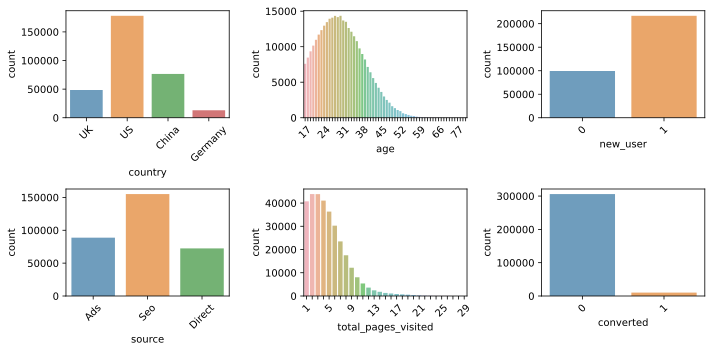

In [3]:
# V.1 Histograms for all types of features 
# Input: Raw_data -- features as columns
# Parameters: num_label -- number of labels kept
# Code:
num_label = 10

fig, axes = plt.subplots(round(len(Raw_data.columns)/3), 3, figsize=(10, 5))

for i, ax in enumerate(fig.axes):
    if i < len(Raw_data.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        plot_ = sns.countplot(x=Raw_data.columns[i], alpha=0.7, data=Raw_data, ax=ax)
        # the following codes is to make xlabel concise
        divisor = round(len(plot_.get_xticklabels())/num_label)+1
        for ind, label in enumerate(plot_.get_xticklabels()):
            if ind % divisor == 0:  # every divisor th label is kept
                label.set_visible(True)
            else:
                label.set_visible(False)
fig.tight_layout()

**Comment: Discribtion of features and target**

- **country:** Most users are from US, Germany has the lowest number
- **Age:** Most users range from 17 to 50. we have two people with age above 100, could be outliers
- **new_user:** We have twice new users as much as old users
- **source:** Around half of users learn our website through clicking the search results
- **Total_pages_visited:** The total pages most people visited range from 1 to 9. The distribution has a long right tail and high values might be grouped into one category
- **Target:** extremely low conversion rate 0.0323, unbalanced response
 

In [ ]:
# conversion rate for each feature
# 1. convert continuous age into age groups 
Raw_data['Age_groups'] = pd.qcut(Raw_data["age"], q=4,labels=np.quantile(Raw_data["age"],q=np.arange(0,1,0.25)))

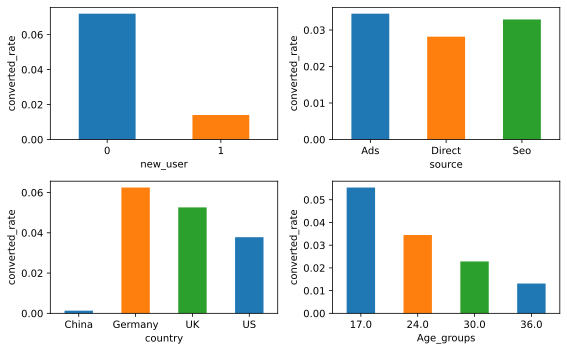

In [6]:
# V.2 Exploratory Analysis
# V.2.1 Relationship between features and binary target

# barplot(category)
# input: object_columns -- list of feature names
#        Raw_data -- features as columns
#        target_name -- name of binary response 
target_name = 'converted'
object_columns = list(['new_user','source','country','Age_groups'])

current_palette = sns.color_palette()
fig, axes = plt.subplots(2, 2, figsize=(8, 5))
# barplot
for i,colname in enumerate(object_columns):
    country_ax = Raw_data.groupby(colname)[target_name].mean().\
    plot.bar(rot = 0,ax=fig.axes[i],color=current_palette[0:3]) # new user
    country_ax.set(ylabel=target_name+'_rate')
fig.tight_layout()

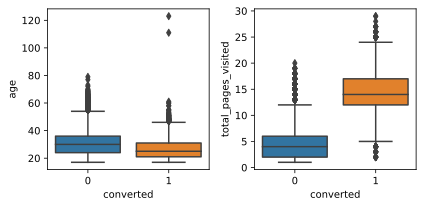

In [11]:
# boxplot(continuous)
# input: value_columns -- list of feature names
#        Raw_data -- features as columns
#        target_name -- name of binary response
target_name = 'converted'
value_columns = list(['age','total_pages_visited'])

current_palette = sns.color_palette()
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i,colname in enumerate(value_columns):
    sns.boxplot(x=target_name, y=value_columns[i], data=Raw_data, ax=fig.axes[i])
fig.tight_layout()

Text(0, 0.5, 'converted_rate')

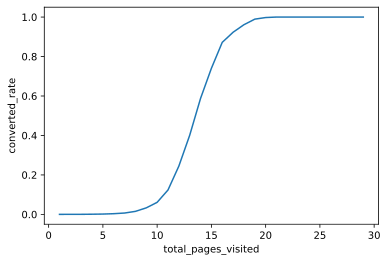

In [22]:
# Groupby based plots: line plot
Raw_data.groupby('total_pages_visited')['converted'].mean().plot()
plt.ylabel('converted_rate')

**Comment: how would each feature affect the final conversion rate**

- **new_user:** Conversion rate for old users is around 7 times the rate for new users.
-   **source:** Users who learn the website through typing URL have a little bit lower conversion rate.Not much difference.Consider dropping this feature in model fitting.
-  **country:** Germany has the highest conversion rate while the user population from Germany is small. The conversion rate for UK is higher than US though they have small user population. Surprisingly, the conversion rate for China is almost zero.
-      **age:** Younger poeple seem to have a higher conversion rate. A barplot was drawed after converting the value age into quantile factor (17,24,30,36). The conversion rate drops as the age increases.
- **total_pages_visited:** the more pages people visited, the more likely they would make the payment(at least 5-10 pages visited)

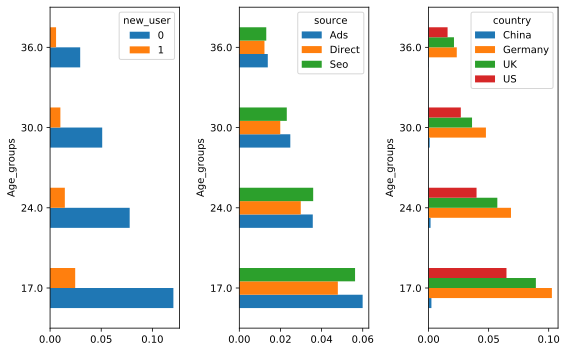

In [6]:
# V.2.2 Barplot: Interaction between two categorical features
fig, axes = plt.subplots(1, 3, figsize=(8,5))
Raw_data.groupby(['Age_groups','new_user'])['converted'].mean().unstack(1).plot.barh(ax=axes[0])
Raw_data.groupby(['Age_groups','source'])['converted'].mean().unstack(1).plot.barh(ax=axes[1])
Raw_data.groupby(['Age_groups','country'])['converted'].mean().unstack(1).plot.barh(ax=axes[2])
fig.tight_layout()

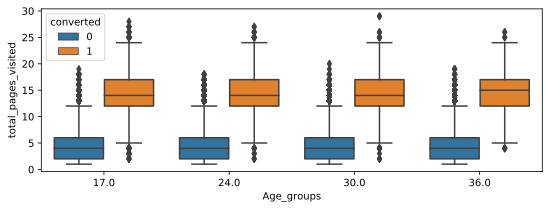

In [7]:
# Boxplot: Interaction between categorical feature and continous feature
plt.figure(figsize=(9,3))
sns.boxplot(x='Age_groups',y='total_pages_visited',data=Raw_data,hue='converted')

[Text(0.5, 0, 'age'),
 Text(1.5, 0, 'new_user'),
 Text(2.5, 0, 'total_pages_visited')]

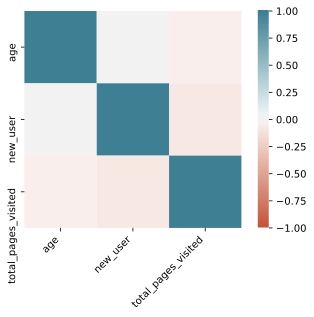

In [25]:
# Correlation Heatmap: interaction among continous variables
# Input: dat -- samples as rows and features as columns
dat = Raw_data[['age','new_user','total_pages_visited']]

corr = dat.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

**Comment:** there is no obvious relationship between age_group and other features

## Part II. Model fitting and evaluation

In [3]:
Raw_data = pd.read_csv("/data/conversion_data.csv")
Raw_data = Raw_data[Raw_data.age < 100]

### Undersampling + dummies + LogisticModel + Classification criterions
This part is only to show the functions commonly used in logistic regression

In [4]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from random import sample

In [24]:
# Convert factors into dummy variables and drop the age_group created before
dumm_vars=['country','source']
for var in dumm_vars:
    # drop the first level depends whether or not you use simple linear or logistic model
    dumm_list = pd.get_dummies(Raw_data[var], prefix=var,drop_first=False)
    Raw_data=Raw_data.join(dumm_list)
    Raw_data.drop(var,axis=1,inplace=True)

**Comment:** source contributes nothing to the final accuracy and was thus removed from the prediction model

In [37]:
# Under-sampling and data splitting (train and 'test' dataset)
X = Raw_data.loc[:, Raw_data.columns != 'converted']
y = Raw_data.loc[:, 'converted']
rus = RandomUnderSampler(random_state=931)
X_rus, y_rus = rus.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus,test_size=0.2, random_state=30)

In [38]:
# simple logistic regression with classification problem
logreg = LogisticRegression(solver = 'liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [39]:
# evaluation on the test dataset
## overall accuracy
from sklearn import metrics
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on train set: 0.94
Accuracy of logistic regression classifier on test set: 0.94


In [14]:
## confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1967  103]
 [ 137 1873]]


In [28]:
## precision, recall, F1-score and report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      2070
           1       0.95      0.93      0.94      2010

    accuracy                           0.94      4080
   macro avg       0.94      0.94      0.94      4080
weighted avg       0.94      0.94      0.94      4080



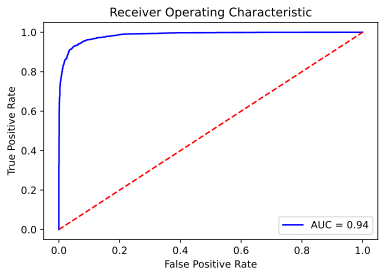

In [62]:
## V: AUC curve
y_pred_score = logreg.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_score)
auc = metrics.roc_auc_score(y_test, y_pred)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [73]:
# Coefficients of features
pd.DataFrame({'features': Raw_data.columns.drop('converted'), 'coefficient': logreg.coef_[0,:]}
, columns=['features', 'coefficient']).sort_values(by=['coefficient'],ascending=False)

,features,coefficient
2,total_pages_visited,0.778216
4,country_Germany,0.391295
5,country_UK,0.182746
0,age,-0.069051
6,country_US,-0.128967
7,source_Ads,-0.913921
9,source_Seo,-0.927458
8,source_Direct,-1.068598
1,new_user,-1.718951
3,country_China,-3.355052


### Stratified splitting + Weighted classes + RandomForest + importance + partial dependence + Shap

In [3]:
Raw_data = pd.read_csv("/data/conversion_data.csv")
Raw_data = Raw_data[Raw_data.age < 100]

In [4]:
# Convert factors into dummy variables and drop the age_group created before
dumm_vars=['country','source']
for var in dumm_vars:
    # drop the first level depends whether or not you use simple linear or logistic model
    dumm_list = pd.get_dummies(Raw_data[var], prefix=var,drop_first=False)
    Raw_data=Raw_data.join(dumm_list)
    Raw_data.drop(var,axis=1,inplace=True)

In [5]:
# data splitting (train and 'test' dataset)
from sklearn.model_selection import train_test_split
X = Raw_data.loc[:, Raw_data.columns != 'converted']
y = Raw_data.loc[:, 'converted']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, 
                                                    random_state=30,
                                                    shuffle=True,
                                                    stratify=y)

In [5]:
# baseline performence
y_test.value_counts(normalize=True)
# baseline: 0.9677

0    0.967742
1    0.032258
Name: converted, dtype: float64

In [47]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 200 decision trees
# Tuning on min_samples_leaf an max_depth help a lot
rf = RandomForestClassifier(n_estimators = 500, 
                           max_features = 5,
                           min_samples_leaf=30, # default is 1
                           max_depth=8, # default is None
                           class_weight = 'balanced_subsample',
                           random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);
# Actual class predictions
y_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

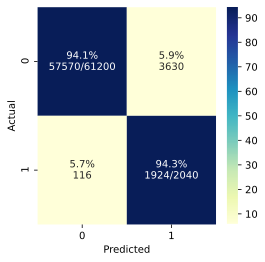

In [6]:
# V.1 plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap="YlGnBu")
    #plt.savefig(filename)
    plt.show()

cm_analysis(y_test, y_pred, rf.classes_, ymap=None, figsize=(4,4))

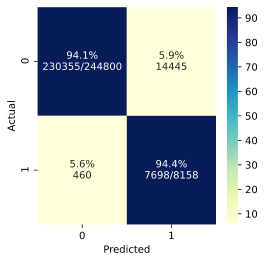

In [7]:
y_train_pred = rf.predict(X_train)
cm_analysis(y_train, y_train_pred, rf.classes_, ymap=None, figsize=(4,4))

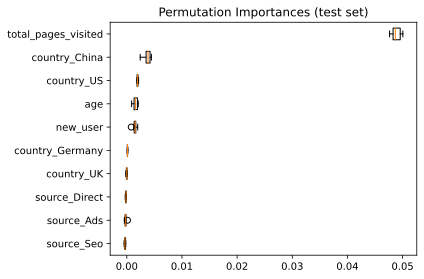

In [40]:
# V.2 Feature permutation-importance on test dataset 
# Prior to inspecting the feature importances, it is important to check that the model predictive performance 
# is high enough. Indeed there would be little interest of inspecting the important features of a non-predictive model.
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Total pages visited is the most important one, by far. Unfortunately, it is probably the least “actionable”.
People visit many pages cause they already want to buy. Also, in order to buy you have to click on
multiple pages.Let’s rebuild the RF without that variable.

### rebuild the model without total_pages_vistited

In [6]:
# data splitting (train and 'test' dataset)
from sklearn.model_selection import train_test_split
X = Raw_data.loc[:, ~Raw_data.columns.isin(['converted','total_pages_visited'])]
y = Raw_data.loc[:, 'converted']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, 
                                                    random_state=30,
                                                    shuffle=True,
                                                    stratify=y)
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 200 decision trees
# Tuning on min_samples_leaf an max_depth help a lot
rf = RandomForestClassifier(n_estimators = 200,  
                           max_features = 5,
                           min_samples_leaf=30, # default is 1
                           max_depth=6, # default is None
                           class_weight = 'balanced_subsample',
                           random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);
# Actual class predictions
y_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

**Comment:** one of my friend mistakely setted the n_estimators as 6 and the model stills return a good result, with no overfitting problem. That is pretty interesting result.(save computational time) 

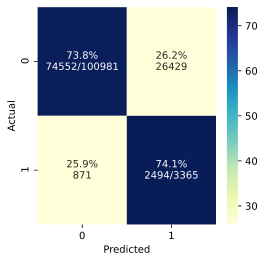

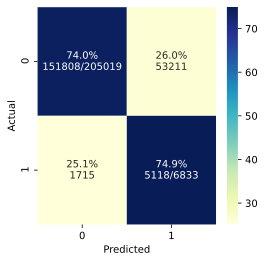

In [11]:
cm_analysis(y_test, y_pred, rf.classes_, ymap=None, figsize=(4,4))
cm_analysis(y_train, y_train_pred, rf.classes_, ymap=None, figsize=(4,4))

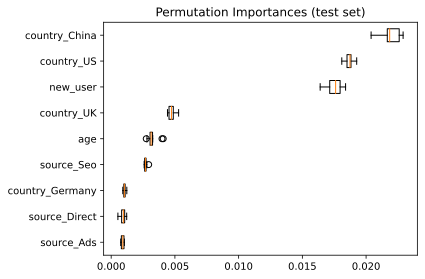

In [26]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Comment: 
1. when I use 1000 estimators, country_China was ranked the top. When the estimator was set as 20, new_user comes the first. Overall, I still prefer more estimators.
2. One way to handle multicollinear features is by performing hierarchical clustering on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster. 

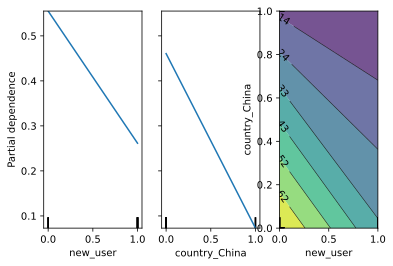

In [62]:
# V.3 Partial dependence
from sklearn.inspection import plot_partial_dependence
features=[1,2,(1,2)]
plot_partial_dependence(rf, X_test, features) 
# Comment: how to change the figure size?

### Tuning process 

In [20]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 3)]
# Number of features to consider at every split
max_features = [3,6,9]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               }
scoring = ['recall', 'precision'] # multiple criterion
# pprint(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight = 'balanced_subsample')
# Random search of parameters, using 10 fold cross validation, 
# search across 20 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid,
                               return_train_score = True,
                               scoring = scoring,
                               n_iter = 9, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 31.0min finished


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced_subsample'),
                   n_iter=9, n_jobs=-1,
                   param_distributions={'max_features': [3, 6, 9],
                                        'n_estimators': [200, 600, 1000]},
                   random_state=42, verbose=2)

In [25]:
pd.DataFrame(rf_random.cv_results_)[['params','mean_test_score']]
# comment: there is no big difference among combinations

,params,mean_test_score
0,"{'n_estimators': 200, 'max_features': 3}",0.961567
1,"{'n_estimators': 600, 'max_features': 3}",0.961345
2,"{'n_estimators': 1000, 'max_features': 3}",0.961302
3,"{'n_estimators': 200, 'max_features': 6}",0.961638
4,"{'n_estimators': 600, 'max_features': 6}",0.961393
5,"{'n_estimators': 1000, 'max_features': 6}",0.961211
6,"{'n_estimators': 200, 'max_features': 9}",0.961602
7,"{'n_estimators': 600, 'max_features': 9}",0.961484
8,"{'n_estimators': 1000, 'max_features': 9}",0.961780


Some conclusions and suggestions:
1. The site is working very well for young users. Definitely let’s tell marketing to advertise and use
marketing channel which are more likely to reach young people.
2. The site is working very well for Germany in terms of conversion. But the summary showed that
there are few Germans coming to the site: way less than UK, despite a larger population. Again,
marketing should get more Germans. Big opportunity.
3. Users with old accounts do much better. Targeted emails with offers to bring them back to the site
could be a good idea to try.
4. Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the
local culture, some payment issue or maybe it is just in English! Given how many users are based in
China, fixing this should be a top priority. Huge opportunity.
5. Maybe go through the UI and figure out why older users perform so poorly? From 30 y/o conversion
clearly starts dropping.
6. If I know someone has visited many pages, but hasn’t converted, she almost surely has high
purchase intent. I could email her targeted offers or sending her reminders. Overall, these are
probably the easiest users to make convert.
As you can see, conclusions usually end up being about:
1. tell marketing to get more of the good performing user segments
2. tell product to fix the experience for the bad performing ones

### Further exploration on SHAP value

- For classification problem, explainer.shap_values will return multiple outputs, organized in a list.
You need to specify which category you would like to set as 1 and use shap_values[i] instead of shap_values
- I made the following graphs using train data, you can use test data either
- The shap package crashes with a certain probability and developers haven't resolved the issue. The only way right now is to rerun the model

In [ ]:
help(explainer)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


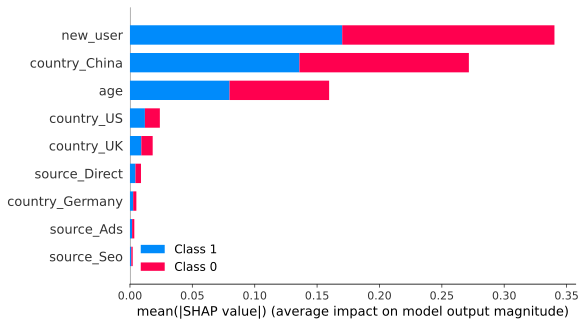

In [17]:
import shap
# load JS visualization code to notebook
shap.initjs()
# V.4 Variable Shap Plot
# Input: model
#        test dataset
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar") # for the barplot, you still need to use shap_values

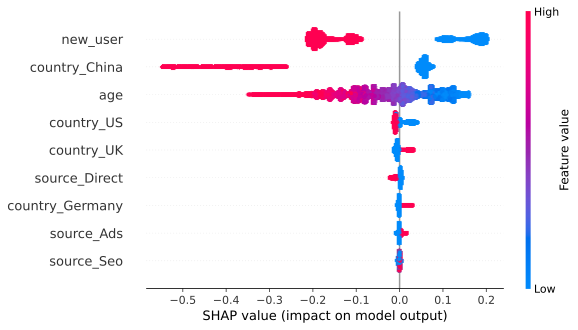

In [44]:
# V.5 Variable scatter plot
# for convertion class = 1
# This one is better for visualization
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values[1], X_train)

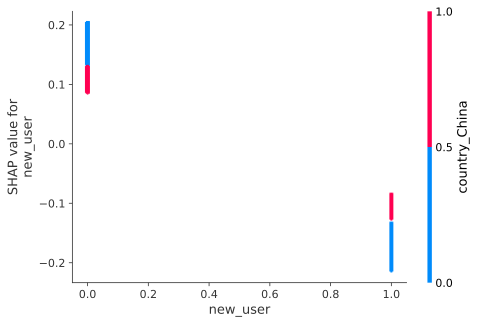

In [56]:
# V.6 SHAP Dependence Plot
# examine trend as variable varies
# examine interaction between features
shap.dependence_plot('new_user', shap_values[1], X_train)
# The function automatically includes another variable that your chosen variable interacts most with. 

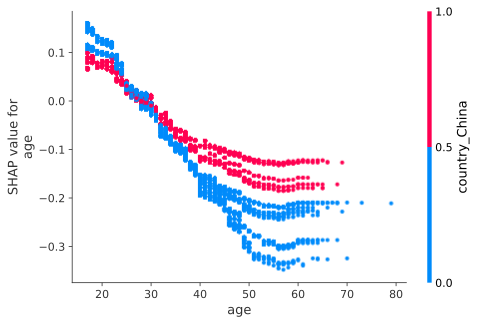

In [60]:
shap.dependence_plot('age', shap_values[1], X_train)

In [46]:
# V.7 Examine the first user
X_train.iloc[0,:]

age                33
new_user            0
country_China       0
country_Germany     0
country_UK          1
country_US          0
source_Ads          0
source_Direct       0
source_Seo          1
Name: 310274, dtype: int64

In [50]:
y_train[0]

0

In [40]:
# for convertion class = 1
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:],X_train.iloc[0,:])


In [41]:
# for convertion class = 0
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:],X_train.iloc[0,:])

As an old user, the first person tends not to purchase

I made a series of experiments to test the effects of splitting proportion and number of trees on feature importance and shap value. The followings are conclusion I got based on this dataset and this problem. (Experiment results can be found in the file "How does hyperparameters affect SHAP and feature importance.pdf" under the folder 1.Qian_Convertion_Rate).
- Feature importance(even with permutation) is not stable when using a low number of trees.
- The splitting proportion won't affect feature importance when you have adequate number of trees.
- Compared with permutation importance, SHAP value is more robust to number of trees and splitting proportion
- Excluding an old feature or including a new feature can somehow affect the ranking of features on feature importance. The SHAP value won't be affected

In [ ]:
# Reference: 
1. SHAP: https://github.com/slundberg/shap
2. Scikit-learn: https://scikit-learn.org/stable/